<a href="https://colab.research.google.com/github/AdrianGuel/StochasticProcesses/blob/main/stochasticsimusOU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchsde

In [ ]:
!pip install KDEpy

In [ ]:
import torch
torch.cuda.empty_cache()
from torch import nn

%matplotlib inline
import matplotlib.pyplot as plt

import torchsde

def plot(ts, samples, xlabel, ylabel, title=''):
    ts = ts.cpu()
    samples = samples.squeeze().t().cpu()
    plt.figure()
    for i, sample in enumerate(samples):
        plt.plot(ts, sample, marker='.')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

In [ ]:
class SDE(nn.Module):

    def __init__(self):
        super().__init__()
        self.thetaf = nn.Parameter(torch.tensor(3), requires_grad=False)  # Scalar parameter.
        self.thetag = nn.Parameter(torch.tensor(0.1), requires_grad=False)
        self.noise_type = "diagonal"
        self.sde_type = "ito"
    
    def f(self, t, y):
        return -self.thetaf * y
    
    def g(self,t,y):
        return self.thetag+ torch.sigmoid(y)*0

In [ ]:
#Theoretical results
from scipy.integrate import odeint
import numpy as np

def Mu(y, t, gamma,Dx):
    return -gamma*y

def Sigma(y, t, gamma, D):
    return -2*gamma*y+D**2

mu0, gamma, Dx, beta0, t_size = 0.5, 3, 0.1, 0.1, 10**3
t = np.linspace(0, 20, t_size)

M = odeint(Mu, mu0, t, args=(gamma, Dx))
S = odeint(Sigma, beta0, t, args=(gamma, Dx))
dM=-gamma*M
dS=-2*gamma*S+Dx**2
G2=(dM**2)/S+0.5*(dS/S)**2
#plt.plot(t,G2 , 'b', label=r'$\theta(t)$')
#plt.show()

In [ ]:
batch_size, state_size, t_size = 10**5, 1, 10**3
sde = SDE()
ts = torch.linspace(0, 20, t_size)
#y0 = torch.full(size=(batch_size, state_size), fill_value=0.4)
y0 = torch.normal(mu0, np.sqrt(beta0), size=(batch_size, state_size))
#with torch.no_grad():
#  ys = torchsde.sdeint(sde, y0, ts)  # (t_size, batch_size, state_size) = (100, 3, 1).
#plot(ts, ys, xlabel='$t$', ylabel='$Y_t$')
if torch.cuda.is_available():
    gpu = torch.device('cuda')
    sde = SDE().to(gpu)
    ts = ts.to(gpu)
    y0 = y0.to(gpu)
    with torch.no_grad():
        ys = torchsde.sdeint(sde, y0, ts, method='srk',adaptive=True)  # (100, 3, 1).
        #ys = torchsde.sdeint(sde, y0, ts, method='srk')    
    #plot(ts, ys, xlabel='$t$', ylabel='$Y_t$')

In [ ]:
from sklearn.neighbors import KernelDensity
from KDEpy import FFTKDE
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

samples = ys.squeeze().t().cpu()
x_size=10**3
p= torch.zeros([x_size, t_size])
p=p.to(gpu)
dp= torch.zeros([x_size, t_size])
dp=dp.to(gpu)
x = np.linspace(-3,3, x_size)
#coordinates = (ts,)
for i in range(0,t_size):
  y = FFTKDE(kernel='gaussian', bw='silverman').fit(samples[:,i].cpu().detach().numpy()).evaluate(x)
  p[:,i] = torch.from_numpy(y)
  #kde = KernelDensity(kernel='gaussian', bandwidth=0.3).fit(samples[:,i].reshape(-1, 1))
  #log_dens = kde.score_samples(x)
  #p[:,i] = torch.from_numpy(np.exp(log_dens))
  #p[:,i]=torch.from_numpy(stats.norm.pdf(x, M[i], np.sqrt(S[i])))
  #kde = gaussian_kde(samples[:,i])

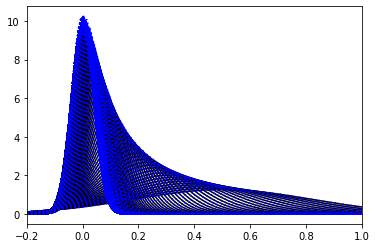

In [ ]:
from scipy import stats
for i in range(0,t_size):
  plt.plot(x,stats.norm.pdf(x, M[i], np.sqrt(S[i])),color='black')
for i in range(0,t_size):
  plt.plot(x,p[:,i].cpu().detach().numpy(),color='blue',linestyle=':')
plt.xlim([-0.2, 1])  
plt.show()

In [ ]:
#for i in range(0,x_size):
#   dp[i,:]=torch.from_numpy(savgol_filter((ts.cpu().detach().numpy(),torch.sqrt(p[i,:]).cpu().detach().numpy()), 105, 1,deriv=1)[1])
#plt.plot(x,dp[:,0].cpu().detach().numpy())
#plt.show()

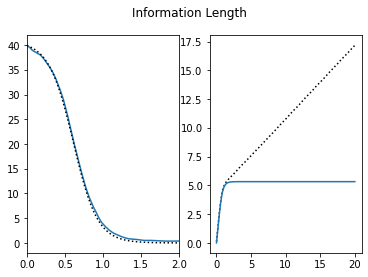

In [ ]:
from scipy import integrate
dp=torch.gradient(torch.sqrt(p),spacing = (ts,),dim=1)[0]# numerical time derivative
xaux=torch.from_numpy(x)
xaux=xaux.to(gpu)
E=torch.trapezoid(4*dp**2,xaux,dim=0)
E=torch.from_numpy(savgol_filter((ts.cpu().detach().numpy(),E.cpu().detach().numpy()),5,1, mode='nearest')[1])
E=E.to(gpu)
IL=torch.cumulative_trapezoid(torch.sqrt(E),ts)
ILt=integrate.cumtrapz(np.sqrt(G2)[:,0], t,initial=0)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Information Length')
ax1.plot(ts.cpu(),E.cpu())
ax1.plot(t,G2,color="black",linestyle=':')
ax2.plot(ts[0:-1].cpu(),IL.cpu(),color="black",linestyle=':')
ax2.plot(t,ILt)
ax1.set_xlim([0, 2])
#ax1.set_ylim([0, 1])
plt.show()